In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import seaborn as sns

In [2]:
DATA_DIR = "../data/raw"
classes = sorted(os.listdir(DATA_DIR))
print("Classes:", classes)
print("Number of classes:", len(classes))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../data/raw'

In [ ]:
data = []

for cls in classes:
    cls_dir = os.path.join(DATA_DIR, cls)
    n_images = len(os.listdir(cls_dir))
    data.append({"class": cls, "count": n_images})

df = pd.DataFrame(data)
df

,class,count
0,battery,945
1,biological,985
2,brown-glass,607
3,cardboard,891
4,clothes,5325
5,green-glass,629
6,metal,769
7,paper,1050
8,plastic,865
9,shoes,1977


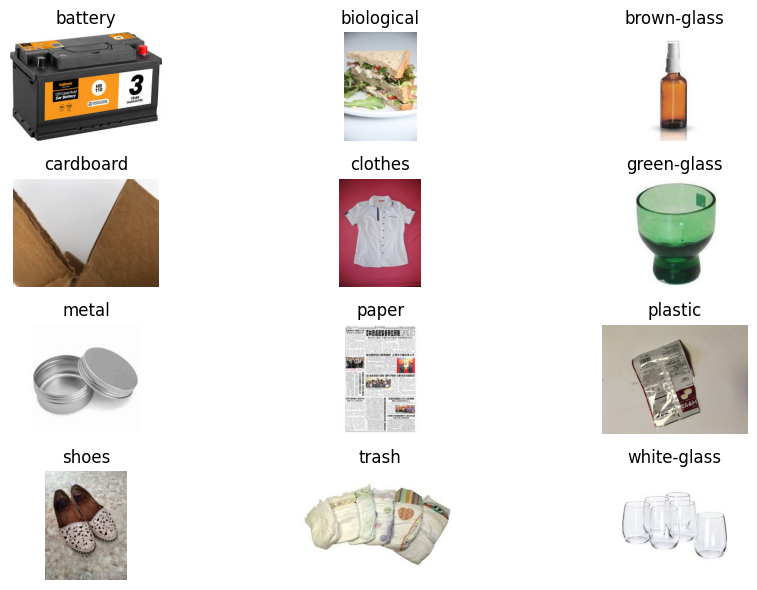

In [ ]:
import random

plt.figure(figsize=(10, 6))
for i, cls in enumerate(classes):
    img_path = os.path.join(DATA_DIR, cls, random.choice(os.listdir(os.path.join(DATA_DIR, cls))))
    img = Image.open(img_path)
    plt.subplot(4, 3, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()

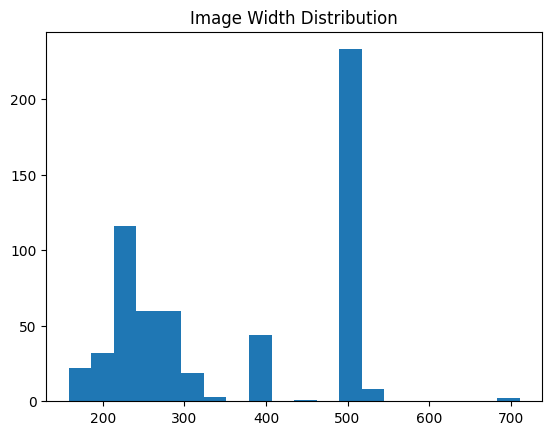

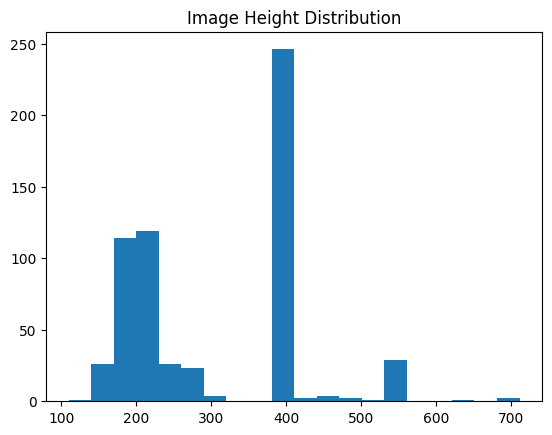

In [ ]:
widths, heights = [], []

for cls in classes:
    for img_name in os.listdir(os.path.join(DATA_DIR, cls))[:50]:
        img = Image.open(os.path.join(DATA_DIR, cls, img_name))
        w, h = img.size
        widths.append(w)
        heights.append(h)

plt.figure()
plt.hist(widths, bins=20)
plt.title("Image Width Distribution")
plt.show()

plt.figure()
plt.hist(heights, bins=20)
plt.title("Image Height Distribution")
plt.show()

In [ ]:
modes = []
for cls in classes:
    for img_name in os.listdir(os.path.join(DATA_DIR, cls))[:1000]:
        img = Image.open(os.path.join(DATA_DIR, cls, img_name))
        modes.append(img.mode)
print(Counter(modes))

Counter({'RGB': 10130, 'P': 33})


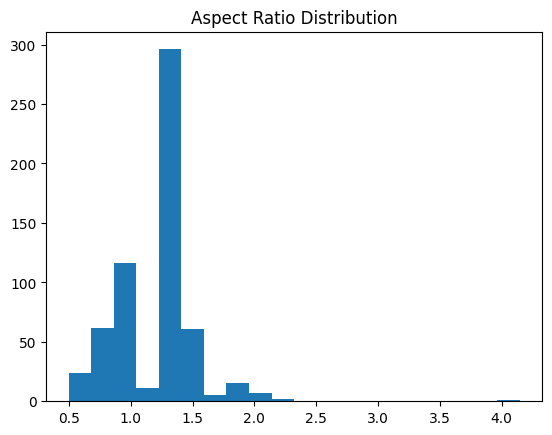

In [ ]:
aspect_ratios = [w/h for w, h in zip(widths, heights)]
plt.hist(aspect_ratios, bins=20)
plt.title("Aspect Ratio Distribution")
plt.show()

In [ ]:
corrupt = []

for cls in classes:
    for img_name in os.listdir(os.path.join(DATA_DIR, cls)):
        try:
            Image.open(os.path.join(DATA_DIR, cls, img_name))
        except:
            corrupt.append((cls, img_name))

len(corrupt)

0

tidak ada image yang corrupt. aman.